<a href="https://colab.research.google.com/github/andresvosa/testNotebooks/blob/main/time_series_fbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
#Installation if needed
#!pip install pystan
#!pip install fbprophet

In [32]:
import pandas as pd
import fbprophet
from fbprophet import Prophet
%matplotlib inline
import matplotlib.pyplot as plt
import datetime as dt


In [36]:

data = []
tab_len = 12
year_rows = [9, 25, 41]
for cnt, ele in enumerate(year_rows):
  year_data = pd.read_csv('/content/tarbimine.csv', skiprows=ele, nrows=tab_len, sep=';', decimal=',')
  year_data.columns.values[0] = 'Month'
  year_data['Year'] = f'202{cnt}'
  year_data['Month_No'] = year_data.reset_index().index + 1
  year_data['Date'] = pd.to_datetime(year_data.Year.astype(str)+ '-' + year_data.Month_No.astype(str))
  #year_data.set_index('Date', inplace=True)
  data.append(year_data)
  #display(year_data)
consumption = pd.concat(data, axis=0)
consumption.drop(['Month', 'Year', 'Month_No'], axis=1, inplace=True)
consumption.dropna(inplace=True)
consumption.set_index('Date', inplace=True, verify_integrity=True)
display(consumption)

,Päev (kWh),Öö (kWh),Kokku (kWh)
Date,,,
2020-01-01,436.410,458.897,895.307
2020-02-01,451.744,496.671,948.415
2020-03-01,445.112,529.966,975.078
2020-04-01,407.123,454.009,861.132
2020-05-01,349.422,378.125,727.547
2020-06-01,226.309,175.161,401.470
2020-07-01,228.542,164.714,393.256
2020-08-01,186.975,181.973,368.948
2020-09-01,173.869,200.843,374.712


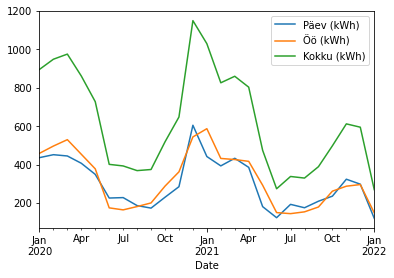

In [37]:
consumption.plot()